In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

<h3>Load data</h3>

In [2]:
iris = load_iris(as_frame=True)
df = pd.concat([iris.data, iris.target], axis=1)
df = df[df['target'].isin([0, 1])]

In [3]:
X = df[['sepal length (cm)', 'petal length (cm)']].values
y = df['target'].values

In [4]:
print(X.shape)
print(y.shape)

(100, 2)
(100,)


### Train-test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(80, 2)
(80,)
(20, 2)
(20,)
(array([0, 1]), array([40, 40]))
(array([0, 1]), array([10, 10]))


<h3>Feature scaling (manual)</h3>

$$ \boldsymbol{z}_j = \frac{\boldsymbol{x}_j - \bar{x}_j}{\sigma_j} $$

In [7]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[:, 0] = (X_train[:, 0] - X_train[:, 0].mean()) / X_train[:, 0].std()
X_train_scaled[:, 1] = (X_train[:, 1] - X_train[:, 1].mean()) / X_train[:, 1].std()

X_test_scaled[:, 0] = (X_test[:, 0] - X_train[:, 0].mean()) / X_train[:, 0].std()
X_test_scaled[:, 1] = (X_test[:, 1] - X_train[:, 1].mean()) / X_train[:, 1].std()

In [8]:
print(X_train_scaled[:, 0].mean(), X_train_scaled[:, 1].mean())
print(X_test_scaled[:, 0].mean(), X_test_scaled[:, 1].mean())

print(X_train_scaled[:, 0].std(), X_train_scaled[:, 1].std())
print(X_test_scaled[:, 0].std(),X_test_scaled[:, 1].std())

-7.924216838262055e-16 -1.3877787807814457e-16
0.1094355804871154 -0.014025076463994136
0.9999999999999999 1.0
1.1610757059129535 1.0557247631719329


**Confirm using sklearn's `StandardScaler`**

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [11]:
X_train_scaled2, X_test_scaled2 = scale_features(X_train, X_test)

In [12]:
print(X_train_scaled2.mean(axis=0))
print(X_test_scaled2.mean(axis=0))
print(X_train_scaled2.std(axis=0))
print(X_test_scaled2.std(axis=0))

[-3.67622599e-15  1.80411242e-16]
[ 0.10943558 -0.01402508]
[1. 1.]
[1.16107571 1.05572476]


### Adaline

In [13]:
class AdalineGD:
    """
    ADAptive LInear NEuron classifier.
    
    Parameters
    ----------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset
    random_state : int
      Random number generator seed for random weight initialization
    
    Attributes
    ----------
    w_ : 1D-array
      Weights after fitting (optimization)
    b_ : scalar
      Bias (intercept) after fitting (optimization)
    errors_ : list
      MSE loss function values in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """
        In the notation below, X is assumed to be nxp, and y nx1.
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.0)
        self.losses_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)  # nx1
            output = self.activation(net_input)  # nx1
            errors = y - output  # nx1
            self.w_ += self.eta * 2.0 * X.T @ errors / X.shape[0]  # px1
            self.b_ += self.eta * 2.0 * np.mean(errors)
            loss = np.mean(errors**2)  # MSE as the loss function
            self.losses_.append(loss)
        return self
        
    def net_input(self, X):
        return X @ self.w_ + self.b_  # nx1
    
    def activation(self, X):
        # Linear activation function
        return X
    
    def predict(self, X):        
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

About the underscore naming convention (e.g., `self.w_`):
- In the Data Science community (and ML libraries like sklearn), an underscore at the end of a variable name tells the user: "This variable was created/learned during the fitting process."
    - Before `fit()`: These variables do not exist yet. If you try to access `model.w_` before training, the code will crash.
    - After `fit()`: These variables are now populated with the "knowledge" the model gained from the data.
    
##### Model Attributes Convention

| Feature | Hyperparameters (No underscore) | Learned Parameters (With underscore) |
| :--- | :--- | :--- |
| **Examples** | `self.eta`, `self.n_iter` | `self.w_`, `self.b_`, `self.losses_` |
| **When are they set?** | During initialization (`__init__`) | During the fitting process (`fit`) |
| **Who sets them?** | The human (user-defined) | The algorithm (learned from data) |
| **Purpose** | Configuration/Settings | The "knowledge" or results of training |

# Model training

### Fit Adaline with scaled features

In [14]:
ada = AdalineGD(eta=0.5, n_iter=20).fit(X_train_scaled, y_train)

In [15]:
def viz_training_progress(clf):
    mse = clf.losses_
    eta = clf.eta
    r = np.arange(1, len(mse) + 1)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(r, mse, marker='o', zorder=2, color='black')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss function (MSE)')
    ax.set_title(f'Learning rate = {eta}')
    ax.grid(True, alpha=0.3, zorder=1);

In [20]:
def plot_decision_boundary(X, y, clf):
    fig, ax = plt.subplots(figsize=(8,6))
    
    # Create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 0].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    
    # Make a Prediction on every grid point
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.Blues)
    
    # Define markers and colors for each (both) class
    markers = ['o', '^']
    colors = ['black', 'orange']
    labels = np.unique(y)
    
    # Plot the original data (each class with a different marker and color)
    for i, label in enumerate(labels):
        X_sub = X[y == label]
        ax.scatter(X_sub[:, 0], X_sub[:, 1], marker=markers[i], color=colors[i])
    ax.set_xlabel('Sepal length (cm)')
    ax.set_ylabel('Petal length (cm)')
    ax.set_title('Adaline classifier decision boundary')
    plt.tight_layout();

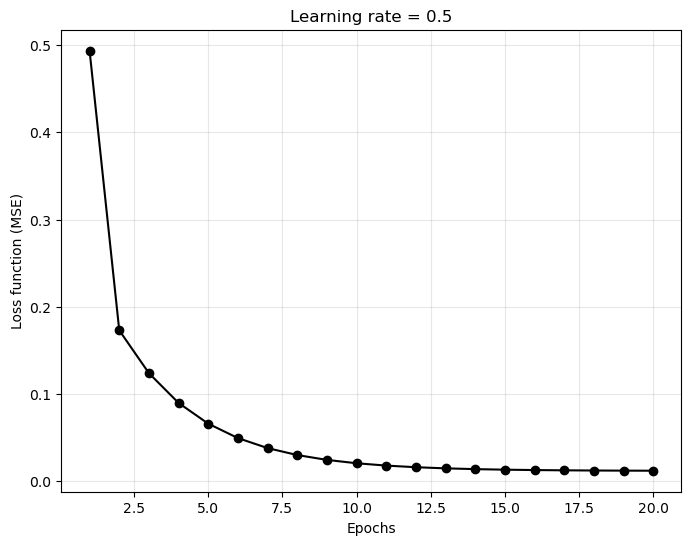

In [17]:
viz_training_progress(clf=ada)

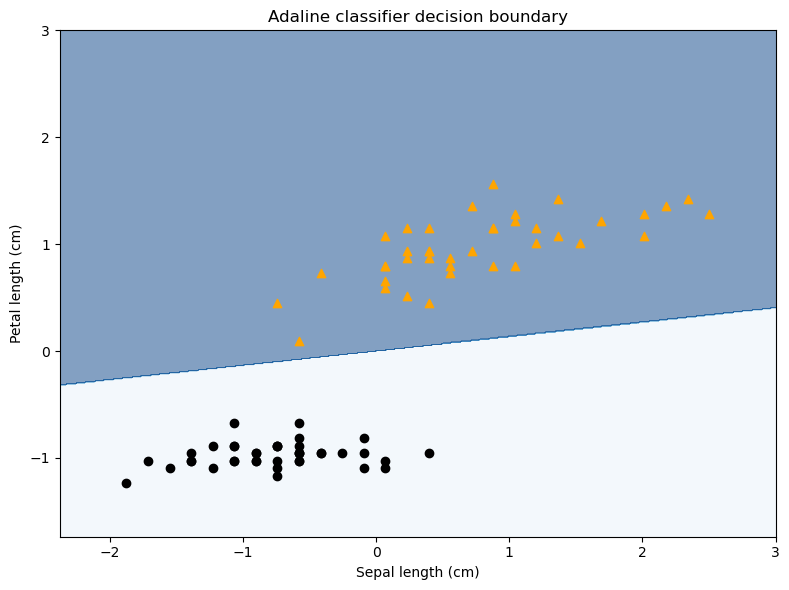

In [21]:
plot_decision_boundary(X=X_train_scaled, y=y_train, clf=ada)

In [25]:
(ada.predict(X_train_scaled) == y_train).sum() / len(y_train)

np.float64(1.0)

- Perfect training accuracy.

In [26]:
(ada.predict(X_test_scaled) == y_test).sum() / len(y_test)

np.float64(1.0)

- Perfect test accuracy.

### Fit Adaline with non-scaled features

In [27]:
ada2 = AdalineGD(eta=0.1, n_iter=20).fit(X_train, y_train)

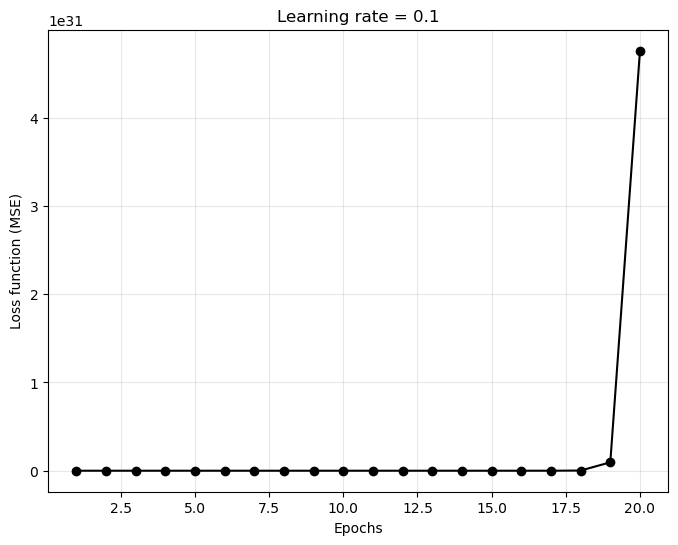

In [28]:
viz_training_progress(clf=ada2)

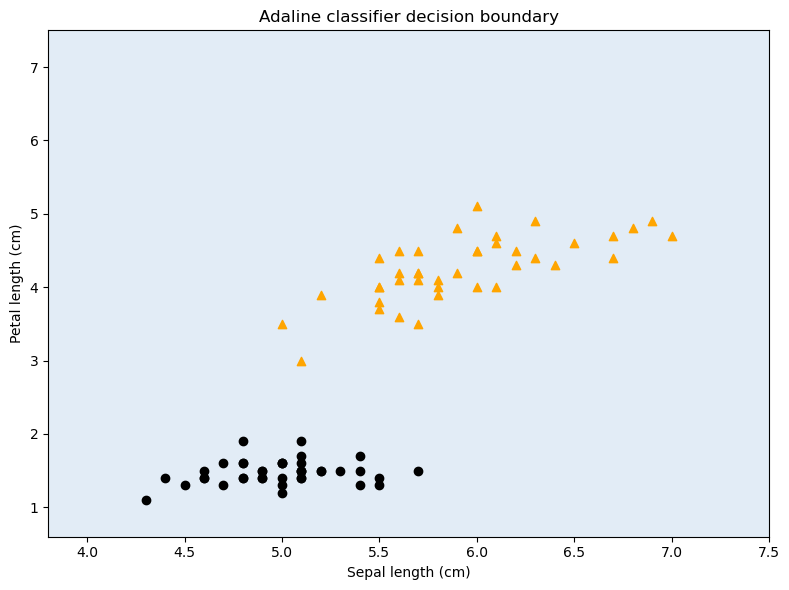

In [29]:
plot_decision_boundary(X_train, y_train, clf=ada2)

In [31]:
ada2.predict(X_train)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
ada2.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

- All **new observations** assigned to the same class.

In [34]:
(ada2.predict(X_train) == y_train).sum() / len(y_train)

np.float64(0.5)

In [35]:
(ada2.predict(X_test) == y_test).sum() / len(y_test)

np.float64(0.5)

In [36]:
# Try with a lower training rate, since 0.1 clearly overshoots the global minima

ada3 = AdalineGD(eta=0.01, n_iter=20).fit(X_train, y_train)

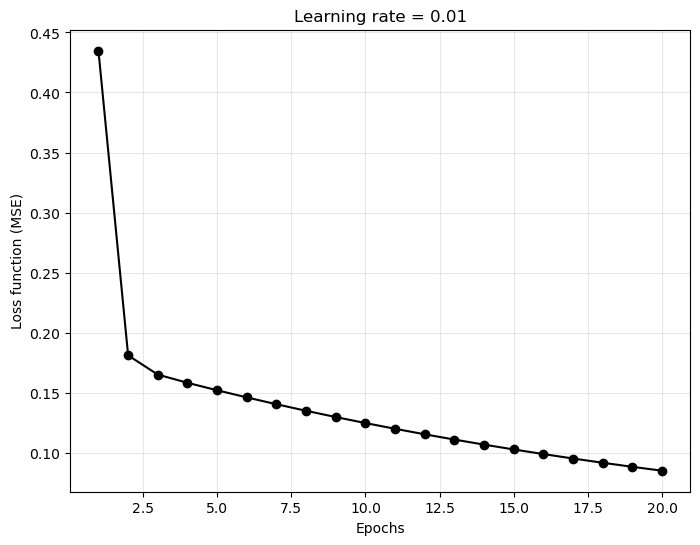

In [37]:
viz_training_progress(clf=ada3)

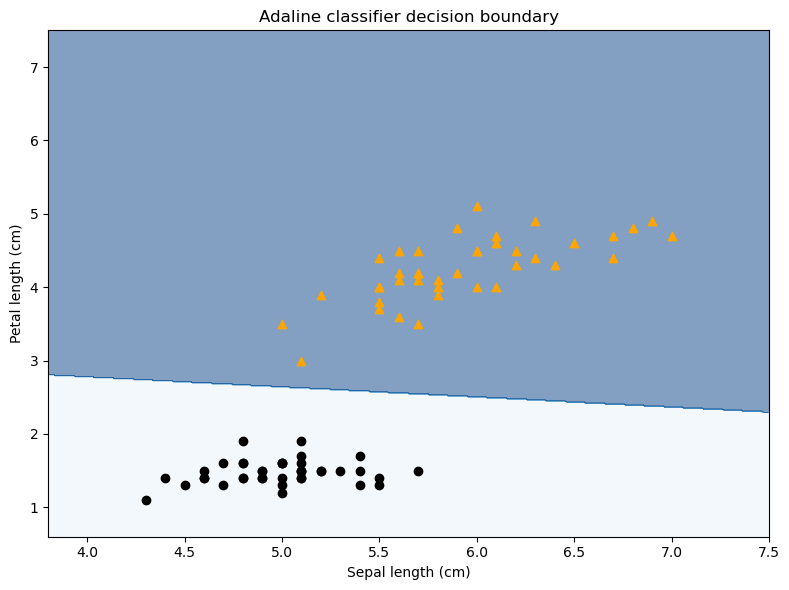

In [38]:
plot_decision_boundary(X_train, y_train, clf=ada3)

In [42]:
(ada3.predict(X_train) == y_train).sum() / len(y_train)

np.float64(1.0)

In [45]:
(ada3.predict(X_test) == y_test).sum() / len(y_test)

np.float64(1.0)

Even though we achieve perfect accuracy with non-scaled features as well, the important thing is that when using scaled features, it is very easy to find a **learning rate** that converges faster to the global minima.